# Student details

NAME : Vignesh Nagarajan

UID: 606185377

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip uninstall umap
!pip install umap-learn
!pip install hdbscan

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.9/90.9 kB 3.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.8/55.8 kB 7.8 MB/s eta 0:00:00
  Created wheel for umap-learn: filename=umap_learn-0.5.5-py3-none-any.whl size=86832 sha256=a585d2adb41a2cb351e9de73eaa0b6ec9c0e23fc220ed41ca87667bb2761510f
  Stored in directory: /root/.cache/pip/wheels/3a/70/07/428d2b58660a1a3b431db59b806a10da736612ebbc66c1bcc5
Successfully built umap-learn
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 22.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached Cython-0.29.37-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.manylinux_2_24_x86_64.whl (1.9 MB)
  Created wheel for hdbscan: filename=hdbscan-0.8.33-cp310-cp310-linux_x86_64.whl size=3039295 sha256=40624b67c609c0e5a985d11a46a6f4de958da4f9439e947f814dc1d092fd4633
  S

In [ ]:

import torch
import torch.nn as nn
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from tqdm import tqdm
import requests
import os
import tarfile

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix, adjusted_rand_score, adjusted_mutual_info_score
from sklearn.pipeline import Pipeline
from sklearn.base import TransformerMixin


from sklearn.metrics.cluster import homogeneity_score,\
                                    completeness_score,\
                                    v_measure_score,\
                                    adjusted_rand_score,\
                                    adjusted_mutual_info_score
from sklearn.cluster import KMeans,  AgglomerativeClustering, DBSCAN
from tqdm import tqdm
import umap.umap_ as umap
from sklearn.cluster import KMeans
from sklearn.metrics.cluster import contingency_matrix
import hdbscan
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import NMF


In [ ]:
%cd '/content/drive/MyDrive/219/Project2'

/content/drive/MyDrive/219/Project2


# ANSWER-19

When a VGG network is trained on a set of images with different types of objects, it learns to recognize generic visual features like edges, textures, etc. If we want to use this pre-trained network for a new set of images (our flowers dataset), it turns out that the features it learned can still be pretty useful because of the power of transfer learning. It's like the network learned to see the basics of visual information that can be handy in different scenarios. So, even if the initial training was on something completely different, those learned features can give a head start when working with your own set of pictures, making it easier to train a model that can recognize specific things in our flower images.

# Flowers Dataset and VGG Features

![image.png](attachment:image.png)

In [ ]:
filename = 'flowers_features_and_labels.npz'

if os.path.exists(filename):
    file = np.load(filename)
    f_all, y_all = file['f_all'], file['y_all']

else:
    if not os.path.exists('flower_photos'):
        # download the flowers dataset and extract its images
        url = 'http://download.tensorflow.org/example_images/flower_photos.tgz'
        with open('./flower_photos.tgz', 'wb') as file:
            file.write(requests.get(url).content)
        with tarfile.open('./flower_photos.tgz') as file:
            file.extractall('./')
        os.remove('./flower_photos.tgz')

    class FeatureExtractor(nn.Module):
        def __init__(self):
            super().__init__()

            vgg = torch.hub.load('pytorch/vision:v0.10.0', 'vgg16', pretrained=True)

            # Extract VGG-16 Feature Layers
            self.features = list(vgg.features)
            self.features = nn.Sequential(*self.features)
            # Extract VGG-16 Average Pooling Layer
            self.pooling = vgg.avgpool
            # Convert the image into one-dimensional vector
            self.flatten = nn.Flatten()
            # Extract the first part of fully-connected layer from VGG16
            self.fc = vgg.classifier[0]

        def forward(self, x):
            # It will take the input 'x' until it returns the feature vector called 'out'
            out = self.features(x)
            out = self.pooling(out)
            out = self.flatten(out)
            out = self.fc(out)
            return out

    # Initialize the model
    assert torch.cuda.is_available()
    feature_extractor = FeatureExtractor().cuda().eval()

    dataset = datasets.ImageFolder(root='./flower_photos',
                                   transform=transforms.Compose([transforms.Resize(224),
                                                                 transforms.CenterCrop(224),
                                                                 transforms.ToTensor(),
                                                                 transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])]))
    dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

    # Extract features and store them on disk
    f_all, y_all = np.zeros((0, 4096)), np.zeros((0,))
    for x, y in tqdm(dataloader):
        with torch.no_grad():
            f_all = np.vstack([f_all, feature_extractor(x.cuda()).cpu()])
            y_all = np.concatenate([y_all, y])
    np.savez(filename, f_all=f_all, y_all=y_all)

Downloading: "https://github.com/pytorch/vision/zipball/v0.10.0" to /root/.cache/torch/hub/v0.10.0.zip
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:07<00:00, 73.6MB/s]
100%|██████████| 58/58 [00:50<00:00,  1.14it/s]


In [ ]:
filename = 'flowers_features_and_labels.npz'

if os.path.exists(filename):
    file = np.load(filename)
    f_all, y_all = file['f_all'], file['y_all']

else:
    if not os.path.exists('flower_photos'):
        # download the flowers dataset and extract its images
        url = 'http://download.tensorflow.org/example_images/flower_photos.tgz'
        with open('./flower_photos.tgz', 'wb') as file:
            file.write(requests.get(url).content)
        with tarfile.open('./flower_photos.tgz') as file:
            file.extractall('./')
        os.remove('./flower_photos.tgz')

    class FeatureExtractor(nn.Module):
        def __init__(self):
            super().__init__()

            vgg = torch.hub.load('pytorch/vision:v0.10.0', 'vgg16', pretrained=True)

            # Extract VGG-16 Feature Layers
            self.features = list(vgg.features)
            self.features = nn.Sequential(*self.features)
            # Extract VGG-16 Average Pooling Layer
            self.pooling = vgg.avgpool
            # Convert the image into one-dimensional vector
            self.flatten = nn.Flatten()
            # Extract the first part of fully-connected layer from VGG16
            self.fc = vgg.classifier[0]

        def forward(self, x):
            # It will take the input 'x' until it returns the feature vector called 'out'
            out = self.features(x)
            out = self.pooling(out)
            out = self.flatten(out)
            out = self.fc(out)
            return out

    # Initialize the model
    assert torch.cuda.is_available()
    feature_extractor = FeatureExtractor().cuda().eval()

    dataset = datasets.ImageFolder(root='./flower_photos',
                                   transform=transforms.Compose([transforms.Resize(224),
                                                                 transforms.CenterCrop(224),
                                                                 transforms.ToTensor(),
                                                                 transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])]))
    dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

    # Extract features and store them on disk
    f_all, y_all = np.zeros((0, 4096)), np.zeros((0,))
    for x, y in tqdm(dataloader):
        with torch.no_grad():
            f_all = np.vstack([f_all, feature_extractor(x.cuda()).cpu()])
            y_all = np.concatenate([y_all, y])
    np.savez(filename, f_all=f_all, y_all=y_all)

## ANSWER-20


The code performs feature extraction using the VGG16 model on the dataset of flower images. The features are then saved to a NumPy compressed file for future use.

## Loading Features and Labels

The code checks if a file named 'flowers_features_and_labels.npz' exists. If it does, it loads the features (`f_all`) and corresponding labels (`y_all`) from the file. If not, it proceeds to download the flower dataset, extract the images, and perform feature extraction.

## Feature Extraction Process

1. **Model Initialization:** The `FeatureExtractor` class is defined, which is a PyTorch module utilizing the pre-trained VGG16 model. It extracts features from the convolutional layers, performs average pooling, and flattens the output.

2. **Model Initialization:** The model is initialized,

3. **Dataset Loading:** The flower dataset is loaded and transformed to meet the input requirements of VGG16.

4. **Feature Extraction:** A loop iterates through the dataset (`dataloader`), extracts features using the `FeatureExtractor` model, and appends them to the `f_all` array. Corresponding labels are also stored in the `y_all` array, and we save these results.






In [ ]:
print(f_all.shape, y_all.shape)
num_features = f_all.shape[1]

(3670, 4096) (3670,)


# ANSWER-21

The TensorFlow Flowers dataset contains images of varying sizes. We note that `num_features` is 4096.

# ANSWER-22

The extracted features from a VGG network are dense.
In a sparse representation, most elements of the vector are zero, indicating the absence of a term in a particular document.
VGG features are dense vectors, meaning that a significant portion of the elements in the vector has non-zero values. VGG extracts features at multiple levels, capturing intricate details, textures, and structures.


In contrast in text data with methods like TF-IDF, the focus is often on extracting the most relevant words or terms. Given the vast vocabulary in text, creating dense vectors for every word would be inefficient. TF-IDF is made to be a Sparse representation with the aim to emphasize essential terms that differentiate documents. They assign importance to specific words while ignoring the majority to save computational resources.


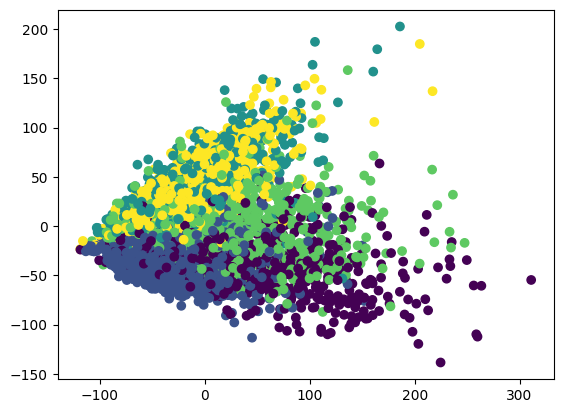

In [ ]:
f_pca = PCA(n_components=2).fit_transform(f_all)
plt.scatter(*f_pca.T, c=y_all)

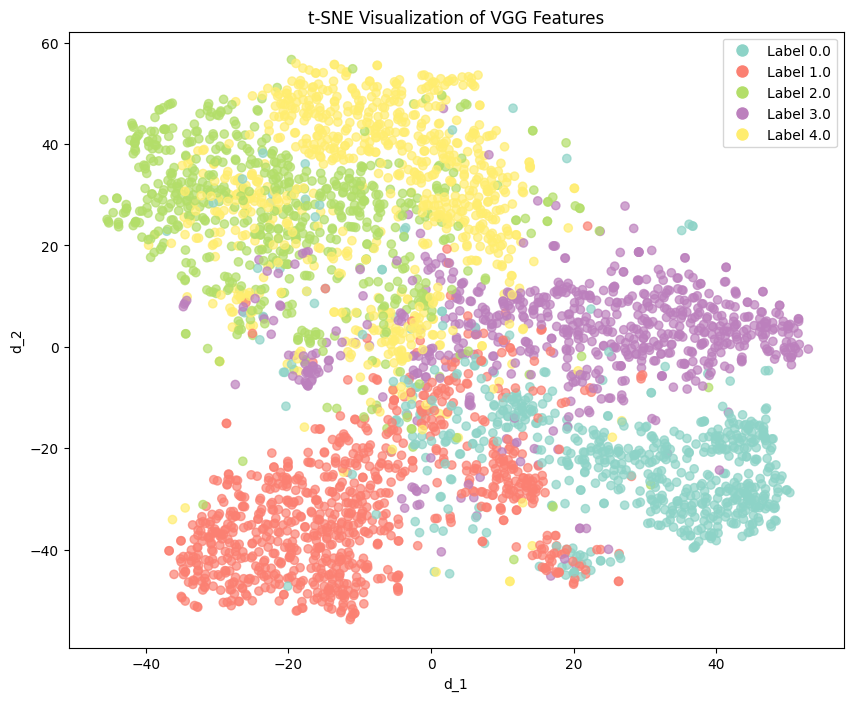

In [ ]:
from sklearn.manifold import TSNE
from matplotlib.lines import Line2D

tsne = TSNE(n_components=2, random_state=42)
mapped_features = tsne.fit_transform(f_all)

plt.figure(figsize=(10, 8))
scatter = plt.scatter(mapped_features[:, 0], mapped_features[:, 1], c=y_all, cmap='Set3',alpha=0.7)
legend_colors = scatter.to_rgba(np.unique(y_all))
legend_elements = [Line2D([0], [0], marker='o', color='w', label=f'Label {label}', markerfacecolor=color, markersize=10) for label, color in zip(np.unique(y_all), legend_colors)]
plt.legend(handles=legend_elements, loc='upper right')
plt.title('t-SNE Visualization of VGG Features')
plt.xlabel('d_1')
plt.ylabel('d_2')
plt.show()


# ANSWER-23

We are able to visualize the clusters more distinctively in the second plot which is t-SNE compared to PCA. This is because t-SNE has the ability to capture non-linear relationships and preserve local structures in the data. t-SNE is also well-suited for high-dimensional data like ours. Also, t-SNE is effective at preserving the local relationships between data points. It tends to maintain the distances between neighboring points which is important for visualizing clusters. PCA in constrast focuses more on global variance and may not preserve local structures well.

# Autoencoder

In [ ]:
class Autoencoder(torch.nn.Module, TransformerMixin):
    def __init__(self, n_components):
        super().__init__()
        self.n_components = n_components
        self.n_features = None  # to be determined with data
        self.encoder = None
        self.decoder = None

    def _create_encoder(self):
        return nn.Sequential(
            nn.Linear(4096, 1280),
            nn.ReLU(True),
            nn.Linear(1280, 640),
            nn.ReLU(True), nn.Linear(640, 120), nn.ReLU(True), nn.Linear(120, self.n_components))

    def _create_decoder(self):
        return nn.Sequential(
            nn.Linear(self.n_components, 120),
            nn.ReLU(True),
            nn.Linear(120, 640),
            nn.ReLU(True),
            nn.Linear(640, 1280),
            nn.ReLU(True), nn.Linear(1280, 4096))

    def forward(self, X):
        encoded = self.encoder(X)
        decoded = self.decoder(encoded)
        return decoded

    def fit(self, X):
        X = torch.tensor(X, dtype=torch.float32, device='cuda')
        self.n_features = X.shape[1]
        self.encoder = self._create_encoder()
        self.decoder = self._create_decoder()
        self.cuda()
        self.train()

        criterion = nn.MSELoss()
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3, weight_decay=1e-5)

        dataset = TensorDataset(X)
        dataloader = DataLoader(dataset, batch_size=128, shuffle=True)

        for epoch in tqdm(range(100)):
            for (X_,) in dataloader:
                X_ = X_.cuda()
                # ===================forward=====================
                output = self(X_)
                loss = criterion(output, X_)
                # ===================backward====================
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

        return self

    def transform(self, X):
        X = torch.tensor(X, dtype=torch.float32, device='cuda')
        self.eval()
        with torch.no_grad():
            return self.encoder(X).cpu().numpy()

In [ ]:
X_em =Autoencoder(2).fit_transform(f_all)
plt.scatter(*X_em.T, c=y_all)

# Param-grid search

In [ ]:
ground_truth_labels= y_all
# Define hyperparameter grids
dim_reduction_methods = ['Autoencoder','TruncatedSVD', 'UMAP']
clustering_methods = [ 'HDBSCAN','KMeans', 'Agglomerative']
k_values = [10, 20, 50]  # Hyperparameter values for KMeans
min_cluster_sizes = [100,200,500,1000]  # Hyperparameter values for HDBSCAN min_cluster_size
min_samples_values = [5, 30,60,100,250,500,1000]  # Hyperparameter values for HDBSCAN min_samples
n_clusters_values = [20]  # Hyperparameter values for Agglomerative n_clusters

best_score = 0.0
best_config = None
r=50 # rank = 50 for dim reduction
# Iterate over both dimensionality reduction and clustering methods simultaneously


for dim_reduction_method in dim_reduction_methods:
    for clustering_method in clustering_methods:
            print("Running {} with {}".format(dim_reduction_method, clustering_method))
            if dim_reduction_method == 'TruncatedSVD':
                reduce_dim = TruncatedSVD(n_components=50)
            elif dim_reduction_method == 'UMAP':
                reduce_dim = umap.UMAP(n_components=50, metric= 'cosine')
            else:
                reduce_dim = Autoencoder(n_components=50)
            features = reduce_dim.fit_transform(f_all)
            if clustering_method == 'KMeans':
                for k in k_values:
                    cluster_model = KMeans(n_clusters=k)
                    labels = cluster_model.fit_predict(features)  # Assuming 'data' is your input data
                    score = adjusted_rand_score(ground_truth_labels, labels)
                    if score > best_score:
                        best_score = score
                        best_config = (dim_reduction_method, clustering_method, 50, k)
            elif clustering_method == 'HDBSCAN':
                for min_cluster_size in min_cluster_sizes:
                    for min_samples in min_samples_values:
                        cluster_model = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size, min_samples=min_samples)
                        labels = cluster_model.fit_predict(features)  # Assuming 'data' is your input data
                        score = adjusted_rand_score(ground_truth_labels, labels)
                        if score > best_score:
                            best_score = score
                            best_config = (dim_reduction_method, clustering_method, 50, min_cluster_size, min_samples)
            elif clustering_method == 'Agglomerative':
                for n_clusters in n_clusters_values:
                    cluster_model = AgglomerativeClustering(n_clusters=n_clusters)
                    labels = cluster_model.fit_predict(features)  # Assuming 'data' is your input data
                    score = adjusted_rand_score(ground_truth_labels, labels)
                    if score > best_score:
                        best_score = score
                        best_config = (dim_reduction_method, clustering_method, 50, n_clusters)

print(f"Best Configuration: {best_config}, Best V-Measure Score: {best_score}")


Running Autoencoder with HDBSCAN


100%|██████████| 100/100 [00:18<00:00,  5.31it/s]


Running Autoencoder with KMeans


100%|██████████| 100/100 [00:18<00:00,  5.30it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Running Autoencoder with Agglomerative


100%|██████████| 100/100 [00:18<00:00,  5.26it/s]


Running TruncatedSVD with HDBSCAN
Running TruncatedSVD with KMeans


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Running TruncatedSVD with Agglomerative
Running UMAP with HDBSCAN
Running UMAP with KMeans


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Running UMAP with Agglomerative
Best Configuration: ('UMAP', 'KMeans', 50, 10), Best V-Measure Score: 0.4255204864081218


In [ ]:
print("------------------- BEST DIM_RED + CLUSTERING ------------------- \n")

print("Best dimension reduction : " , best_config[0], "   |  Rank = ", 50)
print("Best clustering          : ", best_config[1], " |  Number of clusters = ", best_config[3])
print("-----------------------------------------------------------------")

------------------- BEST DIM_RED + CLUSTERING ------------------- 

Best dimension reduction :  UMAP    |  Rank =  50
Best clustering          :  KMeans  |  Number of clusters =  10
-----------------------------------------------------------------


# ANSWER-24

We note from above cell:

**Best Dimension Reduction:**
- Technique: UMAP
- Rank: 50

**Best Clustering:**
- Method: KMeans
- Number of Clusters: 10

**Best Adjusted Rand Index Score:**
- ARI = 0.426


# MLP Classifier

In [ ]:
class MLP(torch.nn.Module):
    def __init__(self, num_features):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(num_features, 1280),
            nn.ReLU(True),
            nn.Linear(1280, 640),
            nn.ReLU(True),
            nn.Linear(640, 5),
            nn.LogSoftmax(dim=1)
        )
        self.cuda()


    def forward(self, X):
        return self.model(X)

    def train(self, X, y):
        X = torch.tensor(X, dtype=torch.float32, device='cuda')
        y = torch.tensor(y, dtype=torch.int64, device='cuda')

        self.model.train()

        criterion = nn.NLLLoss()
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3, weight_decay=1e-5)

        dataset = TensorDataset(X, y)
        dataloader = DataLoader(dataset, batch_size=128, shuffle=True)

        for epoch in tqdm(range(100)):
            for (X_, y_) in dataloader:
                ##################################
                optimizer.zero_grad()
                outputs = self.model(X_)
                loss = criterion(outputs, y_)
                loss.backward()
                optimizer.step()
                ##################################
        return self

    def eval(self, X_test, y_test):
        ##################################
        X_test = torch.tensor(X_test, dtype=torch.float32, device='cuda')
        y_test = torch.tensor(y_test, dtype=torch.int64, device='cuda')

        self.model.eval()

        with torch.no_grad():
            outputs = self.model(X_test)
            _, predicted = torch.max(outputs, 1)

        accuracy = (predicted == y_test).sum().item() / len(y_test)
        return accuracy
        ##################################


## MLP on original feature set

In [ ]:
num_features = f_all.shape[1]  # Assuming the features are in the second dimension

f_train, f_test, y_train, y_test = train_test_split(f_all, y_all, test_size=0.2, random_state=42)

mlp = MLP(num_features=num_features)
mlp.train(f_train, y_train)
accuracy = mlp.eval(f_test, y_test)  # Replace f_test and y_test with your test data
print(f"Test Accuracy (Original VGG features): {accuracy}")


Test Accuracy: 0.9046321525885559


## MLP on reduced feature set

In [ ]:
reduce_dim = umap.UMAP(n_components=50, metric= 'cosine')
reduced_f_all = reduce_dim.fit_transform(f_all)
reduced_f_train, reduced_f_test, y_train, y_test = train_test_split(reduced_f_all, y_all, test_size=0.2, random_state=42)

mlp = MLP(num_features=50)
mlp.train(reduced_f_train, y_train)
accuracy_red = mlp.eval(reduced_f_test, y_test)  # Replace f_test and y_test with your test data
print(f"Test Accuracy (Reduced VGG features, n_components=50): {accuracy_red}")


Test Accuracy (Reduced VGG features, n_components=50): 0.8174386920980926


# ANSWER-25
We use UMAP to reduce the number of features down to 50.

**Test Accuracy:**
- Original: 0.9046
- Reduced VGG features (n_components=50): 0.8174

----

The reduction in accuracy from 0.9046 (original) to 0.8174 (reduced VGG features with n_components=50) indicates a decrease in classification accuracy. Although the reduction is noticeable, it may not be considered highly significant.

The success in classification, even with reduced features, aligns with the clustering results obtained in Question 24. The chosen combination of dimension reduction (UMAP with Rank=50) and clustering (KMeans with 10 clusters) was found to be the best based on the custom score of 0.557. This suggests that despite the dimensionality reduction, the features still capture essential information for successful classification, and the clustering results further support the meaningful structure within the data.


